In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import mctorch
import mctorch.optim as moptim
import OurMethod
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import scipy.optimize

from torch.utils.data import DataLoader, TensorDataset

## Create the Train and Test data.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
N = 1000
#theta = np.random.uniform(0, 2*np.pi, N)
theta = np.random.uniform(0, np.pi, N)
r = np.sqrt(np.random.uniform(0, 4, N))
x = r * np.cos(theta)
y = r * np.sin(theta)
data = np.stack([x, y], axis=1)
labels = x**2 + y**2
data_tensor = torch.tensor(data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

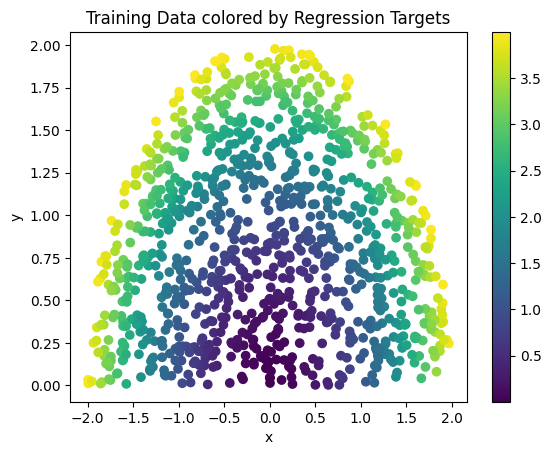

In [4]:
plt.title("Training Data colored by Regression Targets")
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(x,y,c=labels)
plt.colorbar()
plt.show()

In [5]:
N_t = 3000
#theta_t = np.random.uniform(0, 2*np.pi, N_t)
theta_t = np.random.uniform(np.pi, 2*np.pi, N_t)
#r_t = np.sqrt(np.random.uniform(4, 16, N_t))
r_t = np.sqrt(np.random.uniform(0, 4, N_t))
x_t = r_t * np.cos(theta_t)
y_t = r_t * np.sin(theta_t)
data_t = np.stack([x_t, y_t], axis=1)
labels_t = x_t**2 + y_t**2
data_tensor_t = torch.tensor(data_t, dtype=torch.float32)
labels_tensor_t = torch.tensor(labels_t, dtype=torch.float32).unsqueeze(1)

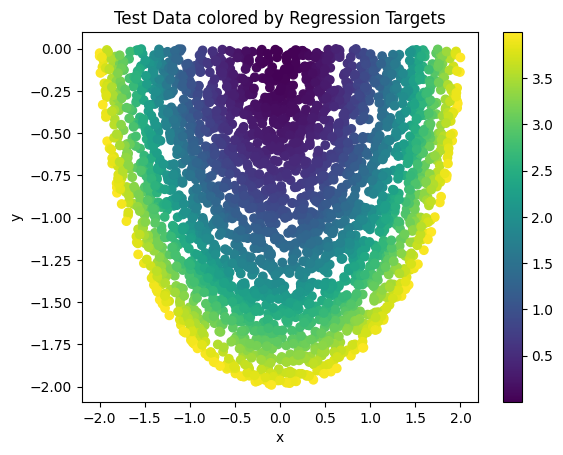

In [6]:
plt.title("Test Data colored by Regression Targets")
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(x_t,y_t,c=labels_t)
plt.colorbar()
plt.show()

## Define the Model Architecture and train as usual

In [7]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

In [8]:
model = MLP()

learning_rate = 0.01
num_epochs = 5000
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [9]:
loss_history = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(data_tensor)
    loss = criterion(output, labels_tensor)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

Epoch 500/5000, Loss: 0.000152
Epoch 1000/5000, Loss: 0.000057
Epoch 1500/5000, Loss: 0.000041
Epoch 2000/5000, Loss: 0.000041
Epoch 2500/5000, Loss: 0.000063
Epoch 3000/5000, Loss: 0.000034
Epoch 3500/5000, Loss: 0.000058
Epoch 4000/5000, Loss: 0.000049
Epoch 4500/5000, Loss: 0.000056
Epoch 5000/5000, Loss: 0.001830


Training completed: 5000 epochs, learning rate = 0.01, final training loss = 0.001830


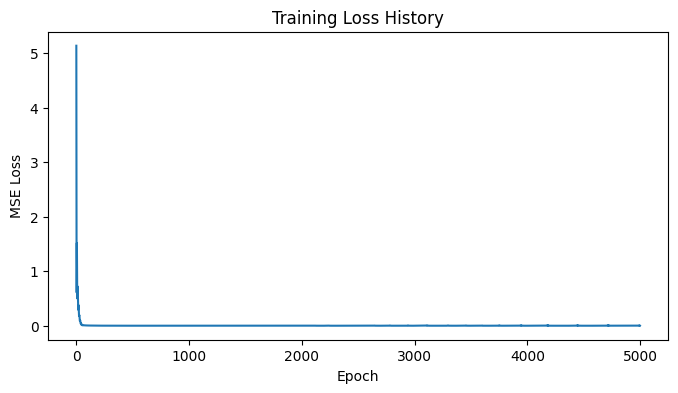

In [10]:
final_loss = loss_history[-1]
print(f"Training completed: {num_epochs} epochs, learning rate = {learning_rate}, final training loss = {final_loss:.6f}")

plt.figure(figsize=(8,4))
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss History")
plt.show()

In [11]:
'''grid_points = 100
x_test = np.linspace(-1, 1, grid_points)
y_test = np.linspace(-1, 1, grid_points)
X_test, Y_test = np.meshgrid(x_test, y_test)
test_data = np.stack([X_test.ravel(), Y_test.ravel()], axis=1)
test_tensor = torch.tensor(test_data, dtype=torch.float32)
model.eval()
with torch.no_grad():
    preds_test = model(test_tensor).squeeze().numpy().reshape(X_test.shape)

plt.figure(figsize=(6,6))
contour = plt.contourf(X_test, Y_test, preds_test, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Contour Plot of Network Predictions (f(x,y))")
plt.show()'''

'grid_points = 100\nx_test = np.linspace(-1, 1, grid_points)\ny_test = np.linspace(-1, 1, grid_points)\nX_test, Y_test = np.meshgrid(x_test, y_test)\ntest_data = np.stack([X_test.ravel(), Y_test.ravel()], axis=1)\ntest_tensor = torch.tensor(test_data, dtype=torch.float32)\nmodel.eval()\nwith torch.no_grad():\n    preds_test = model(test_tensor).squeeze().numpy().reshape(X_test.shape)\n\nplt.figure(figsize=(6,6))\ncontour = plt.contourf(X_test, Y_test, preds_test, levels=50, cmap=\'viridis\')\nplt.colorbar(contour)\nplt.xlabel("x")\nplt.ylabel("y")\nplt.title("Contour Plot of Network Predictions (f(x,y))")\nplt.show()'

In [12]:
outs_train = model(data_tensor)
out_test = model(data_tensor_t)

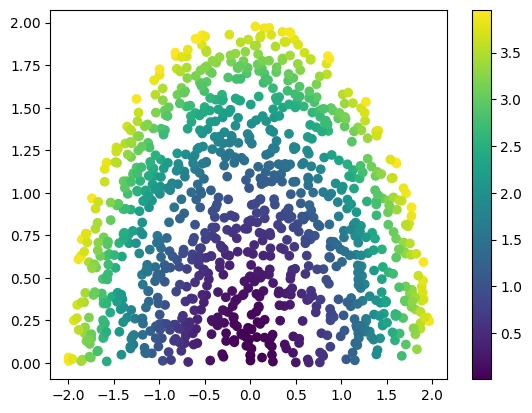

In [13]:
plt.scatter(x,y,c=outs_train.reshape((outs_train.shape[0],)).detach())
plt.colorbar()
plt.show()

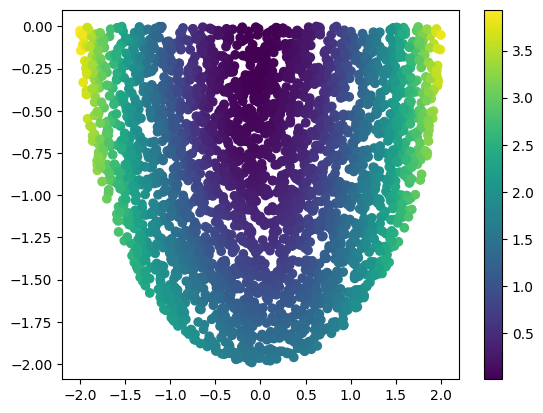

In [14]:
plt.scatter(x_t,y_t,c=out_test.reshape((out_test.shape[0],)).detach())
plt.colorbar()
plt.show()

In [15]:
def quickMSE(preds,truths):
    sse = np.sum([(preds[i]-truths[i])**2 for i in range(preds.shape[0])])
    mse = sse/preds.shape[0]
    return mse

In [16]:
# test MSE
no_sym_MSE_test = quickMSE(out_test.reshape((out_test.shape[0],)).detach(), labels_tensor_t )
print(no_sym_MSE_test)

0.81812775


In [17]:
# train MSE
no_sym_MSE_train = quickMSE(outs_train.reshape((outs_train.shape[0],)).detach(), labels_tensor )
print(no_sym_MSE_train)

0.00047795722


In [18]:
# While the training MSE is great, the test MSE is not as great.
# Can symmetry enforcement improve this?

## Discover symmetry from the training data

In [19]:
def mlp_scalar_func(pt):
    pt_tensor = torch.tensor(pt[None, :], dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        val = model(pt_tensor).item()
    return val

In [20]:
epsilon = 1e-6
grads_list = []
for pt in data:
    df = scipy.optimize.approx_fprime(pt, mlp_scalar_func, epsilon)
    grads_list.append(df)

grads = np.array(grads_list)

In [21]:
poly = PolynomialFeatures(degree=1, include_bias=True)
x_np = data[:, 0]
y_np = data[:, 1]
f_x = grads[:, 0]
f_y = grads[:, 1]

extB = np.column_stack([
    x_np * f_x,
    y_np * f_x,
    f_x,
    x_np * f_y,
    y_np * f_y,
    f_y
])

#U, S, Vt = np.linalg.svd(extB, full_matrices=False)
#P = Vt[-1, :]

In [22]:
extB = torch.tensor(extB).float()
p = OurMethod.tryDimV(extB, 1, criterion=torch.nn.L1Loss(), optimizer=moptim.rAdagrad, n_epochs=1000, lr=1e-1)
P = np.array(p[1].detach())

/home/ben/.local/lib/python3.12/site-packages/mctorch/nn/manifolds/stiefel.py:50: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2422.)
  q, r = torch.qr(X)


In [23]:
print("Recovered infinitesimal generator coefficients (up to scale):")
print(f"a: {P[0][0]:.4f}, b: {P[1][0]:.4f}, c: {P[2][0]:.4f}, d: {P[3][0]:.4f}, e: {P[4][0]:.4f}, f: {P[5][0]:.4f}")
print("Ground truth coefficients for rotation (-y, x): a=0, b=-1, c=0, d=1, e=0, f=0")

Recovered infinitesimal generator coefficients (up to scale):
a: 0.0012, b: 0.7144, c: -0.0135, d: -0.6996, e: -0.0059, f: 0.0037
Ground truth coefficients for rotation (-y, x): a=0, b=-1, c=0, d=1, e=0, f=0


In [24]:
'''directional_deriv = -y_np * f_x + x_np * f_y
mean_deriv = np.mean(np.abs(directional_deriv))
std_deriv = np.std(directional_deriv)

print(f"Mean absolute directional derivative along (-y, x): {mean_deriv:.6f}")
print(f"Standard deviation of directional derivative: {std_deriv:.6f}")

plt.figure(figsize=(8,4))
plt.hist(directional_deriv, bins=50)
plt.xlabel("Directional Derivative along (-y,x)")
plt.ylabel("Frequency")
plt.title("Histogram of Directional Derivative")
plt.show()'''

'directional_deriv = -y_np * f_x + x_np * f_y\nmean_deriv = np.mean(np.abs(directional_deriv))\nstd_deriv = np.std(directional_deriv)\n\nprint(f"Mean absolute directional derivative along (-y, x): {mean_deriv:.6f}")\nprint(f"Standard deviation of directional derivative: {std_deriv:.6f}")\n\nplt.figure(figsize=(8,4))\nplt.hist(directional_deriv, bins=50)\nplt.xlabel("Directional Derivative along (-y,x)")\nplt.ylabel("Frequency")\nplt.title("Histogram of Directional Derivative")\nplt.show()'

## Now we will enforce (with regularization) the symmetry we just learned

In [25]:
def SymTerm(model,X,VF,Connection=None):
    # This is the derivative of the model with respect to the images.
    X = X.requires_grad_(True)
    output = model(X)
    comp_funcs = torch.stack([VF(x) for x in X])
    grads = torch.stack([torch.mul(torch.autograd.grad( #this is a bit clunky. But we have to differentiate each component of the output.
        outputs=output[:,i],
        inputs=X,
        grad_outputs=torch.ones_like(output[:,i]),
        create_graph=True
    )[0],comp_funcs) for i in range(output.shape[1])])
    grads = torch.sum(grads, dim=2)

    return torch.transpose(grads,0,1) #X_f

In [26]:
def vector_field_loss(y_pred, y_target, X_f, symmetry_loss_weight=0.5, criterion_model=nn.CrossEntropyLoss(), criterion_sym=nn.MSELoss()):
    model_loss = criterion_model
    if symmetry_loss_weight==0:
        symmetry_loss = torch.tensor([0.0]) #100*criterion_sym(X_f, torch.zeros_like(X_f))
        total_loss = model_loss(y_pred, y_target)
    else:
        symmetry_loss = criterion_sym(X_f, torch.zeros_like(X_f))
        total_loss = (1.0 - symmetry_loss_weight) * model_loss(y_pred, y_target) + symmetry_loss_weight * symmetry_loss
    return total_loss, symmetry_loss

In [27]:
def train_with_symmetry(model, trainloader, VF, symmetry_loss_weight=0.5, optimizer=optim.Adam, nosymtime=0.5,
                        criterion_model=nn.CrossEntropyLoss(), criterion_sym=nn.MSELoss(), lr=1e-2, n_epochs=20, batchsize=None):
    #X_tensor = torch.tensor(X).float()
    #y_tensor = torch.tensor(y).float()
    #model = MLP(input_dim)
    optimizer = optimizer(model.parameters(), lr=lr) #optim.Adam(model.parameters(), lr=lr)
    sym_losses=[]

    for epoch in range(n_epochs):
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            #optimizer.zero_grad()
            if epoch < n_epochs*nosymtime:
                temp_symmetry_loss_weight = 0.0
            else:
                temp_symmetry_loss_weight = symmetry_loss_weight

            #if batchsize==None:
             #   batchsize=X.shape[0]

            #inds = np.random.randint(0, high=X.shape[0], size=batchsize)
            #print(inputs.shape)
            y_pred = model(inputs) #model(X[inds])
            #print(y_pred.shape)
            #print(y_pred)
            #print(labels.shape)
            #print(labels)
            #y_targets = y[inds]

            X_f = SymTerm(model,inputs,VF,Connection=None) #VF.apply(model, X) #compute_vector_field_loss(model, X_tensor)
            loss, sym_loss = vector_field_loss(y_pred, labels.reshape(y_pred.shape).float(), X_f,
                                 symmetry_loss_weight=temp_symmetry_loss_weight, criterion_model=criterion_model, criterion_sym=criterion_sym)

            sym_losses += [sym_loss.item()]
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            #if i % 10 == 0:
             #   print(f"Epoch [{epoch + 1}/{n_epochs}], minibatch [{i}], Loss: {loss.item():.6f}")
        if epoch % 10 == 0 or epoch == n_epochs - 1:
            print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.6f}")

    return model, sym_losses

In [28]:
trainDataset = TensorDataset(data_tensor, labels_tensor)
trainDataloader = DataLoader(trainDataset, batch_size=128, shuffle=True, num_workers=4)

testDataset = TensorDataset(data_tensor_t, labels_tensor_t)
testDataloader = DataLoader(testDataset, batch_size=128, shuffle=True, num_workers=4)

In [29]:
model2 = MLP()
#model2.to(device)
#rotVF = lambda x: torch.tensor([-x[1]/torch.sqrt(x[0]**2+x[1]**2),x[0]/torch.sqrt(x[0]**2+x[1]**2)])
#print(f"a: {P[0][0]:.4f}, b: {P[1][0]:.4f}, c: {P[2][0]:.4f}, d: {P[3][0]:.4f}, e: {P[4][0]:.4f}, f: {P[5][0]:.4f}")
rotVF = lambda x: torch.tensor([P[0][0]*x[0] + P[1][0]*x[1] + P[2][0], P[3][0]*x[0] + P[4][0]*x[1] + P[5][0]])
learning_rate2 = 1e-2
num_epochs2 = 4500
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate2)
criterion2 = nn.MSELoss()

In [30]:
loss_history2 = []

for epoch in range(num_epochs2):
    model2.train()
    optimizer2.zero_grad()
    output2 = model2(data_tensor)
    loss2 = criterion2(output2, labels_tensor)
    loss2.backward()
    optimizer2.step()
    loss_history2.append(loss2.item())
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}/{num_epochs2}, Loss: {loss2.item():.6f}")

Epoch 500/4500, Loss: 0.000245
Epoch 1000/4500, Loss: 0.000102
Epoch 1500/4500, Loss: 0.000065
Epoch 2000/4500, Loss: 0.000048
Epoch 2500/4500, Loss: 0.000038
Epoch 3000/4500, Loss: 0.000031
Epoch 3500/4500, Loss: 0.000042
Epoch 4000/4500, Loss: 0.000025
Epoch 4500/4500, Loss: 0.000081


In [31]:
result = train_with_symmetry(model2, trainDataloader, rotVF, symmetry_loss_weight=0.01, criterion_model=criterion2, n_epochs=500,
                    optimizer=optim.Adam, criterion_sym=nn.MSELoss(), lr=1e-3, nosymtime=0.0)

Epoch [1/500], Loss: 0.000382
Epoch [11/500], Loss: 0.000174
Epoch [21/500], Loss: 0.000180
Epoch [31/500], Loss: 0.000127
Epoch [41/500], Loss: 0.000135
Epoch [51/500], Loss: 0.000129
Epoch [61/500], Loss: 0.000126
Epoch [71/500], Loss: 0.000156
Epoch [81/500], Loss: 0.000151
Epoch [91/500], Loss: 0.000144
Epoch [101/500], Loss: 0.000144
Epoch [111/500], Loss: 0.000145
Epoch [121/500], Loss: 0.000157
Epoch [131/500], Loss: 0.000171
Epoch [141/500], Loss: 0.000138
Epoch [151/500], Loss: 0.000142
Epoch [161/500], Loss: 0.000130
Epoch [171/500], Loss: 0.000156
Epoch [181/500], Loss: 0.000142
Epoch [191/500], Loss: 0.000145
Epoch [201/500], Loss: 0.000151
Epoch [211/500], Loss: 0.000155
Epoch [221/500], Loss: 0.000140
Epoch [231/500], Loss: 0.000147
Epoch [241/500], Loss: 0.000144
Epoch [251/500], Loss: 0.000112
Epoch [261/500], Loss: 0.000102
Epoch [271/500], Loss: 0.000126
Epoch [281/500], Loss: 0.000134
Epoch [291/500], Loss: 0.000158
Epoch [301/500], Loss: 0.000131
Epoch [311/500], Lo

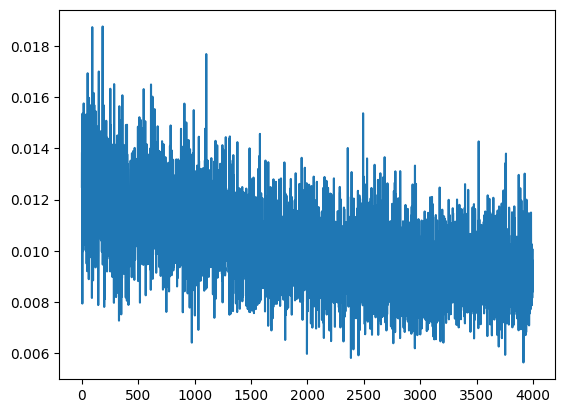

In [32]:
plt.plot(result[1])

In [33]:
model2.eval()

MLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [34]:
sym_preds = model2(data_tensor_t)
np_preds = sym_preds.reshape((sym_preds.shape[0],)).detach().numpy()

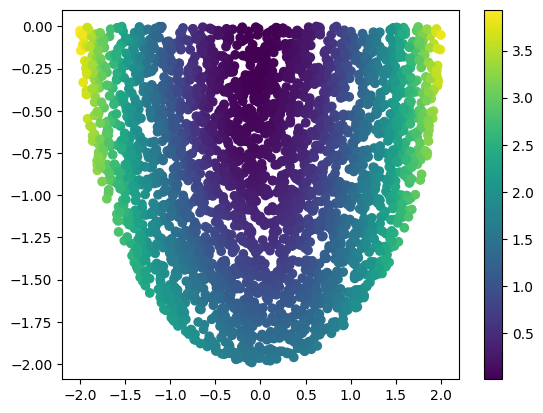

In [35]:
plt.scatter(x_t,y_t,c=out_test.reshape((out_test.shape[0],)).detach())
plt.colorbar()
plt.show()

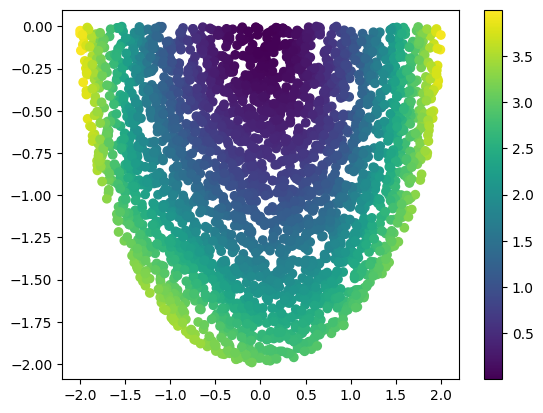

In [36]:
plt.scatter(x_t,y_t,c=np_preds)
plt.colorbar()

In [37]:
sym_MSE_test = quickMSE(np_preds, labels_tensor_t )
print(sym_MSE_test)

0.11481222


In [38]:
sym_preds_train = model2(data_tensor)
np_preds_train = sym_preds_train.reshape((sym_preds_train.shape[0],)).detach().numpy()

In [39]:
sym_MSE_train = quickMSE(np_preds_train, labels_tensor)
print(sym_MSE_train)

4.3244672e-05


In [40]:
print(no_sym_MSE_test)
print(sym_MSE_test)

0.81812775
0.11481222


In [41]:
print(no_sym_MSE_train)
print(sym_MSE_train)

0.00047795722
4.3244672e-05
